<h1>Nucleus segmentation with UNet </h1>
<h4><i>Semantic segmentation vs. Otsu thresholding </i></h4>
<h2> Introduction </h2>
<h2><br></h2>
Microscopy image segmentation is of paramount significance in image processing, particularly for images featuring cell nuclei. This essential initial step involves partitioning the image into distinct regions, each corresponding to specific objects of interest, such as individual nuclei. Accurate segmentation of nuclei is crucial for applications like cell counting, tracking, and cancer diagnosis. It enables researchers to analyze cellular structures and functions more deeply, advancing biomedical research and medical treatments. Automation of data analysis through segmentation enhances efficiency and reliability, benefiting fields like genetics, pathology, and drug development. Overall, microscopy image segmentation plays a pivotal role in unlocking valuable insights from microscopic data and driving scientific. 

Traditionally, segmentation is done manually by scientists using the ImageJ software package. Researchers manually outline the regions of interest. Researchers carefully trace the boundaries of individual nuclei in the image, and then the software creates a closed region based on the drawn outline. If the object of interest has a distinct intensity profile, image thresholding may offer a faster alternative. Otsu thresholding is a popular thresholding technique that will be used as a baseline for model performance. 
<h4><br></h4>
<blockquote>
<h4>What is Otsu Thresholding?</h4>
Otsu thresholding automatically determines an optimal threshold value to convert a grayscale image into a binary image. Otsu's method calculates the threshold value by maximizing the variance between two classes of pixels: the object and the background. The algorithm works by iterating over all possible threshold values and computing the variance for each threshold. The threshold that results in the maximum inter-class variance is then selected as the optimal threshold to segment the image into foreground and background regions. This means that one thresholding operation can be used for images with different lighting. 

![png](https://scipy-lectures.org/_images/sphx_glr_plot_threshold_001.png)<br>
[Otsu thresholding](https://scipy-lectures.org/packages/scikit-image/auto_examples/plot_threshold.html)
</blockquote>

<br>

We create a model with a U-net architecture to segment microscopy images. The model was built intentionally to accommodate the limited computational resources of most experimental scientists and can be quickly trained. Thus, we can quickly segment large batches of realistic microscopy images taken at different imaging conditions. UNet performs semantic segmentation, which means that segmentation is not based on population intensity differences but on high-level patterns. 
<h4><br></h4>
<blockquote>
<h4> What is UNet?</h4>
We build a fast UNet using MobileNetV2 to encode microscopy images and the pix2pix network to decode the encoded image into a segmented image. Skip connections are used to transfer image details to the decoding network. This architecture is based on the segmentation [doumentation](https://www.tensorflow.org/tutorials/generative/pix2pix) provided by TensorFlow.

The pix2pix network is used as the decoding network. This network is a conditional generative adversarial network (cGAN) that learns mapping from input images to output images based on the work by [Isola et al. 2017](https://arxiv.org/abs/1611.07004). The GAN model architecture combines two sub-models, a generator for generating new examples and a discriminator that classifies the generated models as real or fake. These models compete against each other, to generate realistic fake images and discern the real from the fake respectively. In conditional GANS, additional information is provided, in this case pixel class on which the sub-models are conditioned. Below is an example of output generated by the pix2pix cGAN on a facade dataset:
<br></br>
![img](https://www.tensorflow.org/images/gan/pix2pix_1.png)
<br>
[Tensorflow pix2pix documentation](https://www.tensorflow.org/tutorials/generative/pix2pix)
</blockquote>
<br>

Our final model performs similarly to Otsu thresholding in precision, recall and dice loss on high quality images in our test set. Also, we evaluate the ability of our final model to segment real microscopy images of mixed quality. We do not have true masks for this real image set, so the performance is assessed by comparison manually. Our semantic segmentation model is able to discern noise from image quality defects whereas the Otsu model is not. Thus, we expect our model to outperform Otsu thresholding in real situations. Adding lower quality data to the training set would significantly boost UNet's performance, as we are currently training on cleaner images than our use-case, which is not ideal.

<h2><br></h2>
<h2>Project outline</h2> 

<h4>1. Data preparation </h4>

   - Microscopy images are imported, resized, and converted to grey scale. 
   
   - Masks of individually segmented nuclei are combined into one mask for each image.

<h4>2. Visualizing data augmentation </h4>

   - Image augmentation strategies are selected for trial.

   - The resulting images after augmentation are visualized. 
<br>
<h4>3. Establishing baseline segmentation </h4>

   - Images are manually segmented using an Otsu threshold to mimic the capabilities of scientists using ImageJ.

<h4>4. Building segmentation model</h4>

   - An image segmentation model is built with a Unet architecture. 

   - MobilenetV2 is used as an encoding network, and the pix2pix network is used as a decoding network. 

   - Optimal class weights and loss function are identified.

   - Performance metrics are selected including precision, recall and the dice coefficient.

<h4>5. Optimizing image augmentation strategy</h4>

   - The effect of image augmentation on model performance was assessed. 

   - A mixture of all selected augmentations outperformed other models and the test set. 

<h4>6. Fine-tuning selected model</h4>

   - Final model is optimized with additional training using callbacks.

   - Performance of final model on real microscopy images is visualized. 
   
   - Final model matches Otsu thresholding's performance on clean images and is superior on low quality images. 

<h1>Data Preparation</h1>
<h3>Importing microscopy images</h3>

In [1]:
from tensorflow import keras

In [2]:
from PIL import Image
from PIL import ImageFilter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Conv2DTranspose, Activation, concatenate, Conv2D
from tensorflow_examples.models.pix2pix import pix2pix
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import pandas as pd
from sklearn.metrics import precision_score, accuracy_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
import pickle

In [3]:
os.chdir('C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\nucleus_segmentation')

In [4]:
class ImageImport():
    def __init__(self, img_size, path_name,show=False):
        self.img_size = img_size
        self.path_name = path_name
        self.show = show

    def __call__(self):
        self.clean_imgs()
        return self.X

    def clean_imgs(self):
        ids = next(os.walk(self.path_name))[1]
        #X = np.zeros((len(ids),self.img_size,self.img_size,1))
        X = np.zeros((len(ids),self.img_size,self.img_size,3))
        for n, filename in enumerate(ids):
            path = self.path_name+'/'+filename+'/images/'+filename+'.png'
            X[n] = np.repeat((np.array(Image.open(path).resize((self.img_size,self.img_size)).convert('L'))/255)[:,:,None],3,axis=-1)
            #X[n] = np.array(Image.open(path).convert('L').resize((self.img_size,self.img_size)))[:,:,None]/255
            if (self.show)&(n < 5):
                plt.subplot(1,2,1)
                plt.imshow(orig_img)
                plt.subplot(1,2,2)
                plt.imshow(X[n])
                plt.show()
            self.X = X

In [5]:
train_path = './stage1_train'
real_path = './stage2_test_final'
img_size = 128

### Combining masks into target

In [6]:
def combine_masks(path_name,img_size):
    train_ids = next(os.walk(path_name))[1]
    y = np.zeros((len(train_ids),img_size,img_size,1))
    for n,filename in enumerate(train_ids):
        path_name = train_path+'/'+filename+'/masks'
        ids = next(os.walk(path_name))[2] #lists mask files in each stage1_train file
        y_full = np.zeros((len(ids),img_size,img_size,1))
        for m,id in enumerate(ids): 
            mask_name = path_name+'/'+id
            img = np.array(Image.open(mask_name).resize((img_size,img_size)))[:,:,None]
            y_full[m,:,:,:] = img/255
        y[n,:,:,:] = y_full.max(axis=0)
    return y

In [7]:
try:
    with open('y.pkl','rb') as f:
        y = pickle.load(f)
    
except:
    y = combine_masks(train_path,img_size)
    with open('y.pkl','wb') as f:
        pickle.dump(y,f)
    f.close()

### Creating test, validation and train sets

In [8]:
#Assigning test and train sets

#loading X
try:
    with open('X.pkl','rb') as f:
        X = pickle.load(f) 
except:
    X = ImageImport(img_size, train_path)()
    with open('X.pkl','wb') as f:
        pickle.dump(X,f)
    f.close()

#loading X_real
try:
    with open('X_real.pkl','rb') as f:
        X_real = pickle.load(f) 
except:
    X_real = ImageImport(img_size, real_path)()
    with open('X_real.pkl','wb') as f:
        pickle.dump(X_real,f)
    f.close()

data_size = len(X)
train_size = int(data_size*.8)
valid_size = int(data_size*.1)

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size+valid_size], y[train_size:train_size+valid_size]
X_test, y_test = X[train_size+valid_size:],y[train_size+valid_size:]

print(f'Original size of x and y: {X.shape},{y.shape}')
print(f'Shape of train set: {X_train.shape},{y_train.shape}')
print(f'Shape of validation set: {X_valid.shape},{y_valid.shape}')
print(f'Shape of test set: {X_test.shape},{y_test.shape}')

Original size of x and y: (670, 128, 128, 3),(670, 128, 128, 1)
Shape of train set: (536, 128, 128, 3),(536, 128, 128, 1)
Shape of validation set: (67, 128, 128, 3),(67, 128, 128, 1)
Shape of test set: (67, 128, 128, 3),(67, 128, 128, 1)


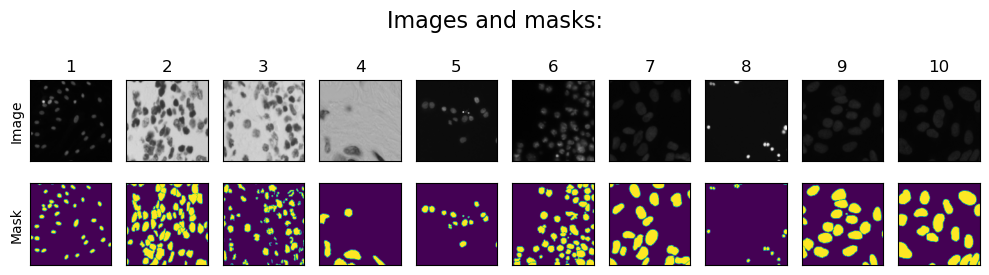

In [9]:
#images and masks
row_max = 10

plt.figure(figsize=(10,3))
plt.suptitle('Images and masks:',size=16)
for num in range(1,row_max+1):
    ax = plt.subplot(2,row_max,num)
    plt.imshow(X[num])
    plt.title(str(num))
    ax.set_xticks([])
    ax.set_yticks([])
    if num == 1:
        plt.ylabel('Image',rotation=90)
    ax = plt.subplot(2,row_max,num+row_max)
    plt.imshow(y[num])
    ax.set_xticks([])
    ax.set_yticks([])
    if num == 1:
        plt.ylabel('Mask',rotation=90)
plt.tight_layout()

<h2><br></br>
<h2>Data augmentation</h2>

<h3>Brightness</h3>

In [10]:
class BrightDistortion(tf.keras.layers.Layer):
    def __init__(self, brightness_delta = (-.1,.8)):
        super().__init__()
        self.brightness_delta = brightness_delta

    def __call__(self,img, training=None):
        if not training:
            return img
        else:
            return tf.clip_by_value(tf.image.random_brightness(img,self.brightness_delta,0,1))

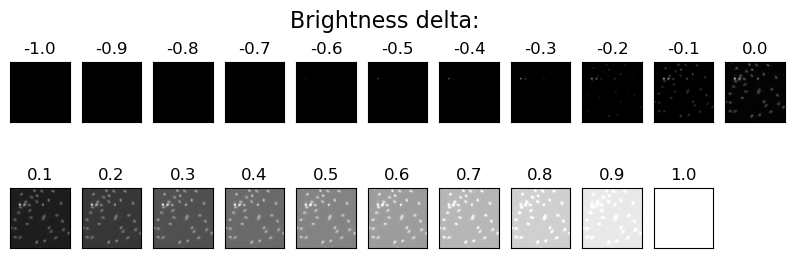

In [11]:
# plot brightness deltas
plt.figure(figsize=(10,3))
plt.suptitle('Brightness delta:',size=16)
brightness_trial = np.round(np.arange(0,21,1)/10-1,1)
for n,brightness in enumerate(brightness_trial):
    img = tf.clip_by_value(tf.image.adjust_brightness(X[1],brightness),0,1)
    ax = plt.subplot(2,11,n+1)
    plt.title(brightness)
    plt.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

### Contrast

In [12]:
print('Random sampling at selectec contrast factors:')

contrast_aug = tf.keras.Sequential([
    tf.keras.layers.RandomContrast((0,2))
])

Random sampling at selectec contrast factors:


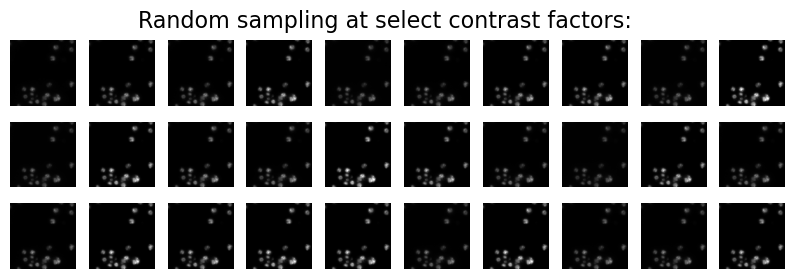

In [13]:
# plot random contrast deltas
plt.figure(figsize=(10,3))
plt.suptitle('Random sampling at select contrast factors:',size=16)
for n in range(30):
    aug_img = tf.clip_by_value(contrast_aug(X[0]),0,1)
    plt.subplot(3,10,n+1)
    plt.imshow(aug_img)
    plt.axis('off')

#### Shift

In [14]:
shift_aug = tf.keras.Sequential([tf.keras.layers.RandomTranslation
    (height_factor=(-.5,.5),
    width_factor=(-.5,.5),
    fill_mode='constant')])

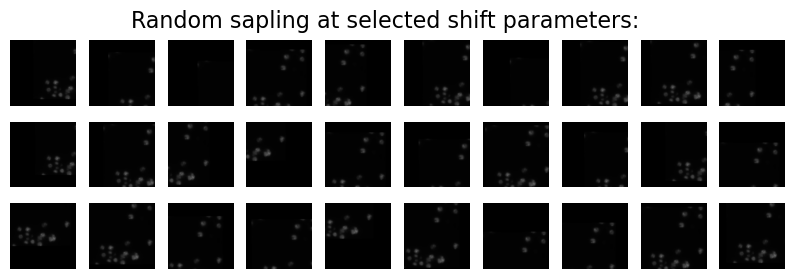

In [15]:
#plot shift
plt.figure(figsize=(10,3))
plt.suptitle('Random sapling at selected shift parameters:',size=16)
for n in range(30):
    aug_img = shift_aug(X[0])
    plt.subplot(3,10,n+1)
    plt.imshow(aug_img)
    plt.axis('off')

#### Blur

In [16]:
class BlurDistortion(tf.keras.layers.Layer):
    def __init__(self,radius=4):
        super().__init__()
        self.radius=np.random.uniform(0,radius)
    
    def __call__(self,imgs,training=None):
        if not training:
            return imgs
        else:
            return np.array(Image.fromarray(np.uint8(X[0]*255)).filter(ImageFilter.GaussianBlur(radius=self.radius)))/255

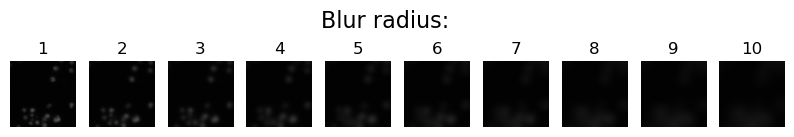

In [17]:
#plot blur radius
plt.figure(figsize=(10,1.75))
plt.suptitle('Blur radius:',size=16)
for num in range(1,11):
    img= Image.fromarray(np.uint8(X[0]*255)).filter(ImageFilter.GaussianBlur(radius=num))
    plt.subplot(1,10,num)
    plt.imshow(np.array(img)/255)
    plt.title(str(num))
    plt.axis('off')

## Otsu thresholding

In [18]:
class ImageClean():
    def __init__(self, img_size, path_name,show=False):
        self.img_size = img_size
        self.path_name = path_name
        self.show = show
        self.X = ImageImport(self.img_size,self.path_name)()

    def __call__(self):
        self.threshold_imgs()
        self.invert_imgs()
        return self.X_inverted

    def threshold_imgs(self):
        X_adjusted = np.zeros(self.X.shape)
        for n,img in enumerate(self.X):
            threshold = threshold_otsu(img)
            img = (img > threshold).astype('uint8')
            X_adjusted[n] = img
        self.X_adjusted = X_adjusted

    def invert_imgs(self):
        X_inverted = np.zeros(self.X_adjusted.shape)
        for n,img in enumerate(self.X_adjusted):
            mean_intensity = np.mean(img)
            if mean_intensity > 0.5:
                img = 1 - img
            X_inverted[n] = img
        self.X_inverted = X_inverted

In [19]:
#cleaning images
X_clean = ImageClean(img_size, train_path,show=False)()
X_real_clean = ImageClean(img_size, real_path,show=False)()
X_test_clean = X_clean[train_size+valid_size:]

C:\Users\corne\AppData\Local\Temp\ipykernel_17624\4002363903.py:16: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (128, 128, 3) looks like that of an RGB image.
  threshold = threshold_otsu(img)


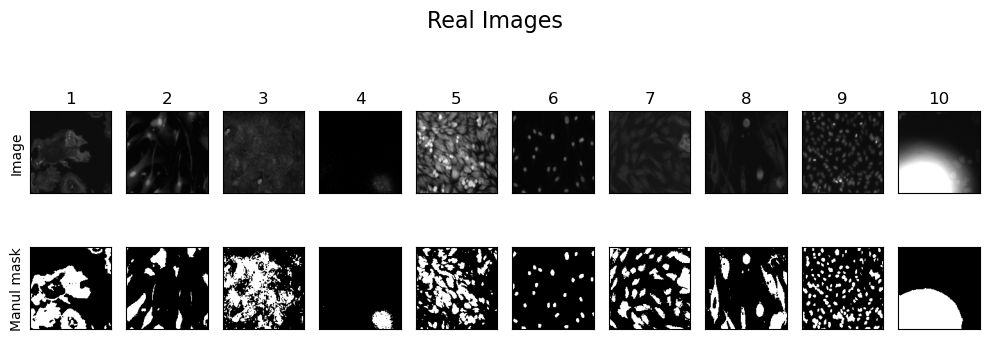

In [20]:
#plot real images + manual thresholds
plt.figure(figsize=(10,4))
plt.suptitle('Real Images',size=16)
for num in range(1,row_max+1):
    ax = plt.subplot(2,row_max,num)
    plt.imshow(X_real[num])
    plt.title(str(num))
    ax.set_xticks([])
    ax.set_yticks([])
    if num == 1:
        plt.ylabel('Image',rotation=90)
    ax = plt.subplot(2,row_max,num+row_max)
    plt.imshow(X_real_clean[num])
    ax.set_xticks([])
    ax.set_yticks([])
    if num == 1:
        plt.ylabel('Manul mask',rotation=90)
plt.tight_layout()

<h2><br></h2>
<h2>Building segmentation model</h2>


<h3>Model architecture</h3>

In [21]:
#load encoding netowrk
base_model = tf.keras.applications.MobileNetV2(input_shape=X[0].shape,include_top=False)

In [22]:
#select outputs for encoding netowrk 
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [23]:
#load decoder network 
#!pip install git+https://github.com/tensorflow/examples.git

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [24]:
#ubuilding unet model
def unet_model(output_channels:int=1, contrast=False,blur = False, bright=False, shift=False,brightness_delta=(-.1,.8),radius=4,contrast_level=1,shift_factor = 0.01):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = tf.keras.layers.Identity()(inputs) #identity layer 
  
  # Data augmentation
  if blur: 
    x = BlurDistortion(radius=radius)(x)
  if contrast:
    x = tf.keras.layers.RandomContrast((0,contrast_level))(x)
  if bright: 
    x = BrightDistortion(brightness_delta=brightness_delta)(x)
  if shift:
    x = tf.keras.layers.RandomTranslation(height_factor=(-1*shift_factor,shift_factor),
                                          width_factor=(-1*shift_factor,shift_factor),
                                          fill_mode='constant')(x)
  
  #clips values 
  x = tf.keras.layers.Lambda(lambda x:tf.clip_by_value(x,0,1))(x)

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1] 
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

<h3><br></h3>
<h3>Selecting loss function</h3>

In [25]:
#function for visualizing predicted mask

#defining activation function
def sigmoid(x):
    return 1/(1+np.exp(-1*x))

#thresholding image
def make_mask(model,title='Predicted Mask',threshold=.5,pic=0): 
    y_pred = model.predict(X_test[pic:1+pic,:,:,:],verbose=0)
    y_pred = sigmoid(y_pred[0])>threshold
    plt.imshow(y_pred)
    plt.axis('off')
    plt.title(title)

In [26]:
#functions for monitoring training, scoring test and scoring train sets

class training_losses():
    def __init__(self,history,description,show=False):
        self.history = history
        self.description = description
        self.min_train_loss = []
        self.min_val_loss = []
        self.show = show
        self.description=description

    def __call__(self):   
        plt.style.use('ggplot')
        plt.figure(figsize=(10,4))
        for n in range(len(self.history)):
            train_loss = self.history[n].history['loss']
            val_loss = self.history[n].history['val_loss']
            self.min_train_loss.append(train_loss[-1])
            self.min_val_loss.append(val_loss[-1])
            train_epochs = len(train_loss)
            val_epochs = len(val_loss)

            ax = plt.subplot(1,2,1)
            plt.plot(range(train_epochs),train_loss,label=self.description[n])
            plt.title('Training loss')
            plt.xlabel('Epoch')
            plt.subplot(1,2,2)
            plt.plot(range(val_epochs),val_loss,label=self.description[n])
            plt.title('Validation loss')
            plt.xlabel('Epoch')
            plt.legend(bbox_to_anchor=(1, 1));
            plt.tight_layout()
            plt.show

        if self.show:
            losses = pd.DataFrame(data = list(zip(self.min_train_loss,self.min_val_loss)),columns=['Train loss','Validation loss'],index=self.description)
            losses.T.plot(kind='bar')
            plt.title('Loss at last training epoch')
            plt.legend(bbox_to_anchor=(1, 1));


class train_metrics():
    def __init__(self,history,description):
        self.history = history
        #self.accuracy = [history[n].history['val_accuracy'][-1] for n in range(len(history))]
        self.precision = [history[n].history['val_precision'][-1] for n in range(len(history))]
        self.recall = [history[n].history['val_recall'][-1] for n in range(len(history))]
        #self.iou = [history[n].history['val_iou_metric'][-1] for n in range(len(history))]
        self.dice = [history[n].history['val_dice_coeff'][-1] for n in range(len(history))]      
        self.description = description

    def __call__(self):
        plt.style.use('ggplot')
        plt.figure(figsize=(10,4))

        metrics = pd.DataFrame(data = list(zip(self.precision,self.recall,self.dice)),columns=['precision','recall','dice coeff'],index=self.description)
        ax = metrics.T.plot(kind='bar')
        plt.legend(bbox_to_anchor=(1, 1))
        plt.title('Train metrics')

#function for scoring test performance
def score_test(models,description,X_test_clean):
    dice_score = []
    iou_score = []
    precision_score = []
    accuracy_score = []
    recall_score = []

    try:
        len(models)
    except:
        models = list(models)

    for model in models:
        y_pred = sigmoid(model.predict(X_test))

        precision = tf.keras.metrics.Precision()
        precision.update_state(y_test,y_pred)
        precision_score.append(precision.result().numpy())
    
        accuracy = tf.keras.metrics.Accuracy()
        accuracy.update_state(y_test,y_pred)
        accuracy_score.append(accuracy.result().numpy())
    
        recall = tf.keras.metrics.Recall()
        recall.update_state(y_test, y_pred)
        recall_score.append(recall.result().numpy())

        dice_ = 0
        #iou_ = 0
        for n in range(len(y_pred)):
            dice_ += dice_coeff(y_test[n],y_pred[n])
            #iou_ += iou_metric(y_test[n],y_pred[n])
        dice_score.append(dice_.numpy()/len(y_test))
        #iou_score.append(iou_.numpy()/len(y_test))

    #adding manual segmentation score
    new_description = description+['Manual Segmentation']
    X_test_clean = X_test_clean[:,:,:,:1]
    precision=tf.keras.metrics.Precision()
    precision.update_state(y_test,X_test_clean)
    precision_score.append(precision.result().numpy())

    accuracy=tf.keras.metrics.Accuracy()
    accuracy.update_state(y_test,X_test_clean)
    accuracy_score.append(accuracy.result().numpy())

    recall = tf.keras.metrics.Recall()
    recall.update_state(y_test,X_test_clean)
    recall_score.append(recall.result().numpy())

    dice_ = 0
    #iou_ = 0
    for n in range(len(X_test_clean)):
        dice_ += dice_coeff(y_test[n],X_test_clean[n])
        #iou_ += iou_metric(y_test[n],X_test_clean[n])
    dice_score.append(dice_.numpy()/len(y_test))
    #iou_score.append(iou_.numpy()/len(y_test))
    
    plt.figure(figsize=(10,4))
    metrics = pd.DataFrame(data = list(zip(precision_score,recall_score,dice_score)),columns=['precision','recall','dice coeff'],index=new_description)
    losses = pd.DataFrame(data = list(zip(precision_score,recall_score,dice_score)),columns=['precision','recall','dice coeff'],index=new_description)
    metrics.T.plot(kind='bar')
    plt.title('Test metrics',size=16)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1, 1));
    

In [27]:
#model metrics
def dice_coeff(y_true, y_pred,smooth=100):
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]),'float32')
    y_pred_f = tf.math.sigmoid(y_pred_f)
    y_true_f = tf.cast(tf.reshape(y_true, [-1]),'float32')

    intersection = tf.reduce_sum(tf.math.multiply(y_true_f,y_pred_f))
    score = tf.math.divide((2. * intersection + smooth),(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))
    return score

class dice_loss(tf.keras.losses.Loss):
    def __init__(self,smooth=100):
        super().__init__()
        self.smooth = smooth

    def call(self, y_true,y_pred):
        loss = 1-dice_coeff(y_true, y_pred,smooth=self.smooth)
        return loss

class bce_dice_loss(tf.keras.losses.Loss):
    def __init__(self,smooth=1):
        super().__init__()
        self.smooth=smooth

    def call(self, y_true,y_pred):
        bce = tf.keras.losses.binary_crossentropy(tf.cast(tf.reshape(y_true, [-1]),'float32'), tf.cast(tf.reshape(y_pred, [-1]),'float32'),from_logits=True)
        dice = dice_loss(smooth=self.smooth)(y_true,y_pred)
        return bce+dice
'''
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')

    intersection = tf.reduce_sum(tf.math.multiply(y_true,y_pred))
    union = tf.math.subtract(tf.math.add(tf.reduce_sum(y_true),tf.reduce_sum(y_pred)),intersection)
    tol = 1e-15
    return tf.math.divide(tf.math.add(intersection,tol),(tf.math.add(union,tol)))
'''

"\ndef iou_metric(y_true, y_pred):\n    y_true = tf.cast(y_true, 'float32')\n    y_pred = tf.cast(y_pred, 'float32')\n\n    intersection = tf.reduce_sum(tf.math.multiply(y_true,y_pred))\n    union = tf.math.subtract(tf.math.add(tf.reduce_sum(y_true),tf.reduce_sum(y_pred)),intersection)\n    tol = 1e-15\n    return tf.math.divide(tf.math.add(intersection,tol),(tf.math.add(union,tol)))\n"

In [28]:
train_epochs = 1

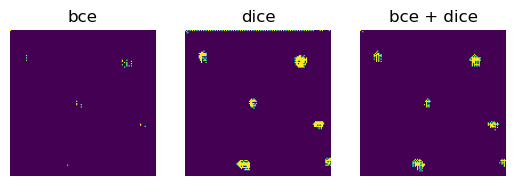

In [29]:
loss_history = []
loss_models = []
loss_description = ['bce','dice','bce + dice']
losses = [tf.keras.losses.BinaryCrossentropy(from_logits=True),dice_loss(smooth=100),bce_dice_loss(smooth=100)]
count = 1

for n in range(len(losses)):
    model = unet_model()
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                                            loss=losses[n], 
                                            metrics=[dice_coeff,tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Accuracy(name='accuracy')])
    _loss_history = model.fit(X_train,y_train, epochs=train_epochs,validation_data=(X_valid,y_valid),verbose=0)

    loss_history.append(_loss_history)
    loss_models.append(model)
    plt.subplot(1,3,count)
    make_mask(model,loss_description[n])
    count +=1
    loss_models[n] = model

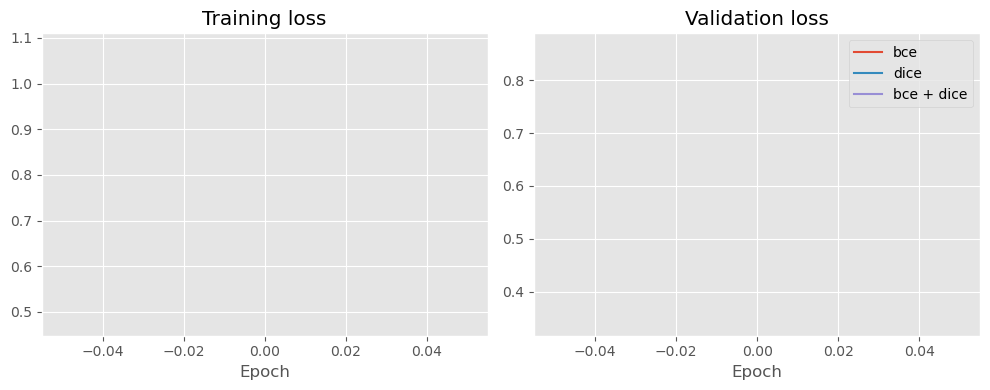

In [30]:
training_losses(loss_history,loss_description)()

<Figure size 1000x400 with 0 Axes>

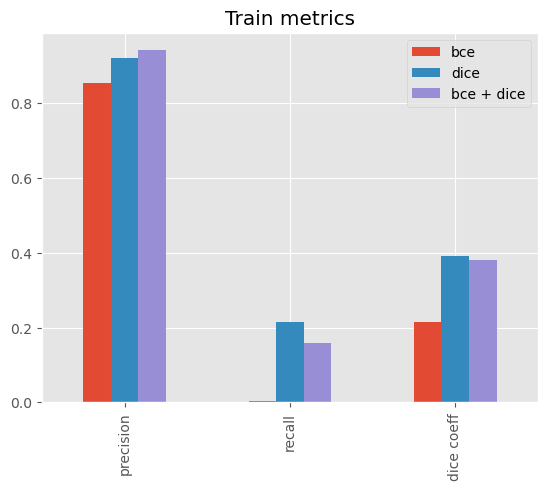

In [31]:
train_metrics(loss_history,loss_description)()

3/3 [==============================] - 1s 310ms/step


<Figure size 1000x400 with 0 Axes>

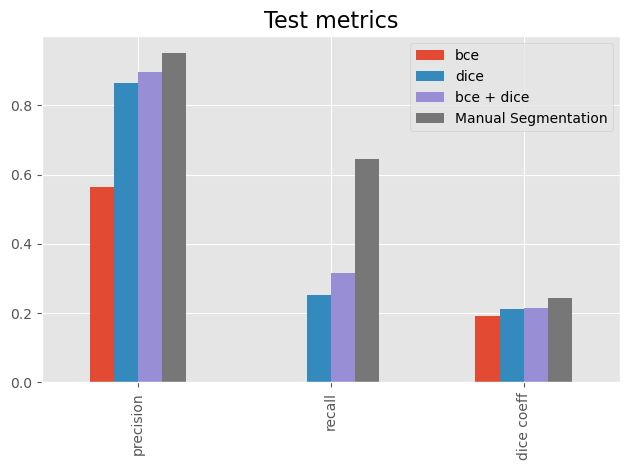

In [32]:
score_test(loss_models,loss_description,X_test_clean)

In [33]:
del loss_models 

We see a combination loss function of binary cross entropy and dice loss outperforms on the test set. This loss function will be used going forward.

<h3>Selecting weights</h3>

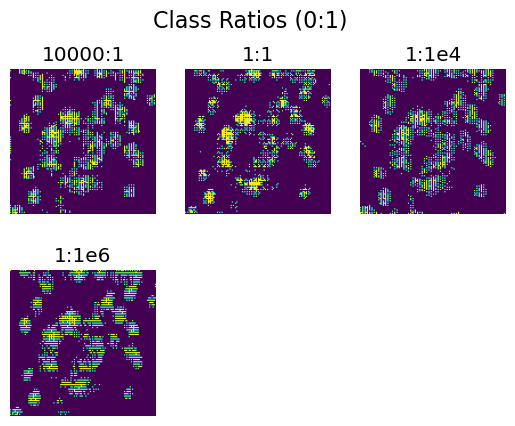

In [34]:
'''
#defining class weights
average_pixel = np.mean(X_train)
weight_for_0 = (1/(1-average_pixel))
weight_for_1 = (1/average_pixel)
'''
'''
weights = [{0:1, 1:1},{0:weight_for_0,1:weight_for_1},{0:weight_for_0,1:weight_for_1*1000},{0:weight_for_0,1:weight_for_1*10000},{0:weight_for_0,1:weight_for_1*100000},{0:weight_for_0,1:weight_for_1*1000000}]
weight_description = ['No weights','Weights','Weights x 1000','Weights x 10000','Weights x 100000','Weights x 1000000']
assert len(weights) == len(weight_description)
'''

weights = [{0:10000,1:1},{0:1,1:1},{0:1,1:10000},{0:1,1:1000000}]
weight_description = ['10000:1','1:1','1:1e4','1:1e6']

weight_history = []
weight_models = []

count = 1

plt.suptitle('Class Ratios (0:1)',fontsize=16)
for n in range(len(weights)):
    model = unet_model()
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                                            loss=bce_dice_loss(smooth=100), 
                                            metrics=[dice_coeff,tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])

    _weight_history = model.fit(X_train,y_train, epochs=train_epochs,validation_data=(X_valid,y_valid),class_weight = weights[n],verbose=0)
    weight_history.append(_weight_history)
    weight_models.append(model)
    plt.subplot(2,3,count)
    make_mask(model,weight_description[n],pic=8)
    count += 1
    weight_models[n] = model

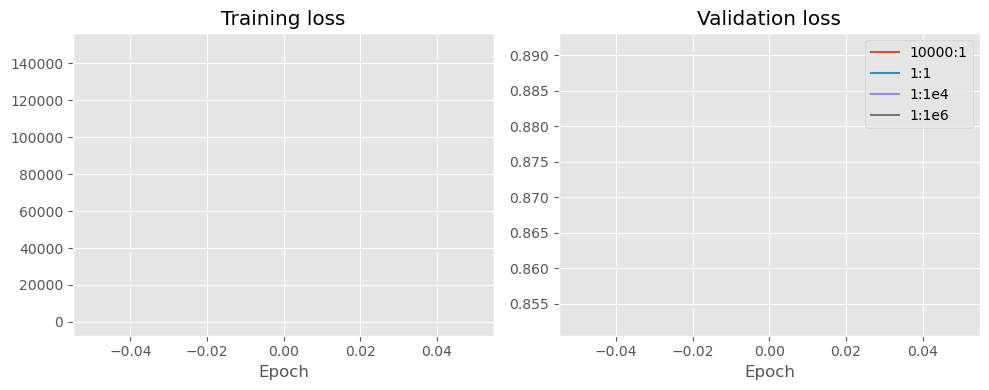

In [35]:
training_losses(weight_history,weight_description)()

<Figure size 1000x400 with 0 Axes>

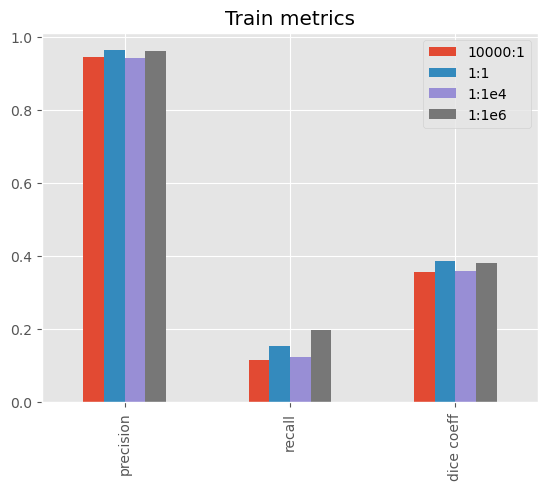

In [36]:
train_metrics(weight_history,weight_description)()

3/3 [==============================] - 1s 311ms/step


<Figure size 1000x400 with 0 Axes>

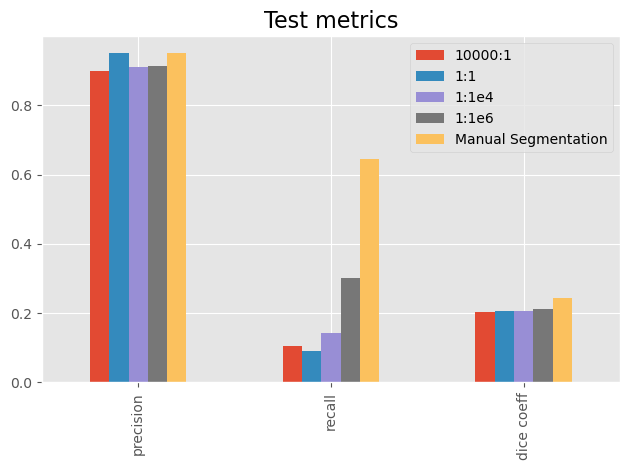

In [37]:
score_test(weight_models,weight_description,X_test_clean)

In [38]:
weight_for_0 = 1
weight_for_1 = 1000000

In [39]:
del weight_models 

We see that class weights of 1 and 1e6 for 0 and 1 respectively outperform on the test set and are used going forward. 

<h3><br></h3>
<h3>Selecting optimal image augmentation strategy</h3>



In [40]:
#building models with different image segmentation strategies
aug_models = [unet_model(),
     unet_model(bright=True),
     unet_model(bright=True,brightness_delta=(-.1,.5)),
     unet_model(bright=True,brightness_delta=(-.1,.2)),
     unet_model(contrast=True), 
     unet_model(contrast=True,contrast_level = .6), 
     unet_model(contrast=True,contrast_level = .2), 
     unet_model(blur=True, radius=2), 
     unet_model(blur=True, radius=4),
     unet_model(blur=True, radius=6),
     unet_model(shift=True,shift_factor=0.001),
     unet_model(shift=True, shift_factor=0.005),
     unet_model(bright=True,radius=4,brightness_delta=(-.1,.5),contrast=True,contrast_level=.2,blur=True,shift=True,shift_factor=0.001)]

aug_description = ['No augmentation',
     'Brightness - High',
     'Brightness - Medium',
     'Brightness - Low',
     'Contrast - High',
     'Contrast - Medium',
     'Contrast - Low',
     'Blur - Low',
     'Blur - Medium',
     'Blur - High',
     'Shift - Low',
     'Shift - High',
     'Select augmentations']

assert len(aug_description) == len(aug_models)

In [41]:
#training models
aug_history = []

for n in range(len(aug_models)):
    model = aug_models[n]

    model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                                            loss=bce_dice_loss(smooth=100),
                                            metrics=[dice_coeff,tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Accuracy(name='accuracy')])
    print("Training "+aug_description[n]+'...')
    _history = model.fit(X_train,y_train, epochs=train_epochs,validation_data=(X_valid,y_valid),class_weight = {0:weight_for_0, 1:weight_for_1},verbose=0)
    aug_history.append(_history)
    aug_models[n] = model

Training No augmentation...
Training Brightness - High...
Training Brightness - Medium...
Training Brightness - Low...
Training Contrast - High...
Training Contrast - Medium...
Training Contrast - Low...
Training Blur - Low...
Training Blur - Medium...
Training Blur - High...
Training Shift - Low...
Training Shift - High...
Training Select augmentations...


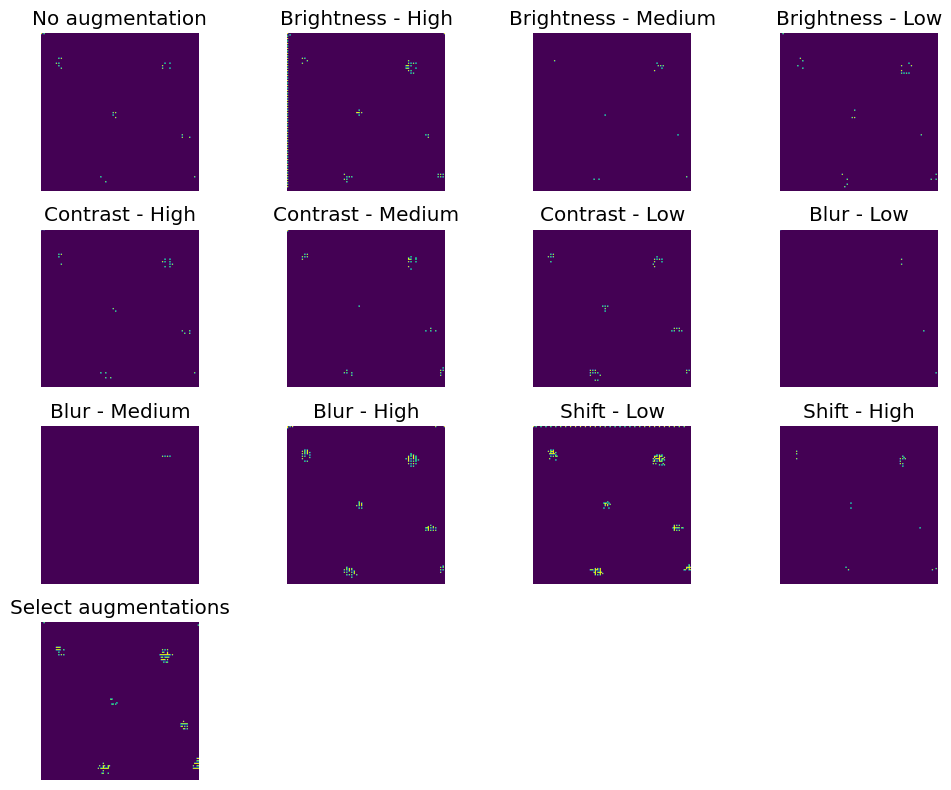

In [42]:
count = 1

plt.figure(figsize=(10,8))
for n,model in enumerate(aug_models):
    plt.subplot(4,int(np.ceil(len(aug_models)/4)),count)
    count +=1
    make_mask(model,aug_description[n],pic=0)
plt.tight_layout()

### Model metrics

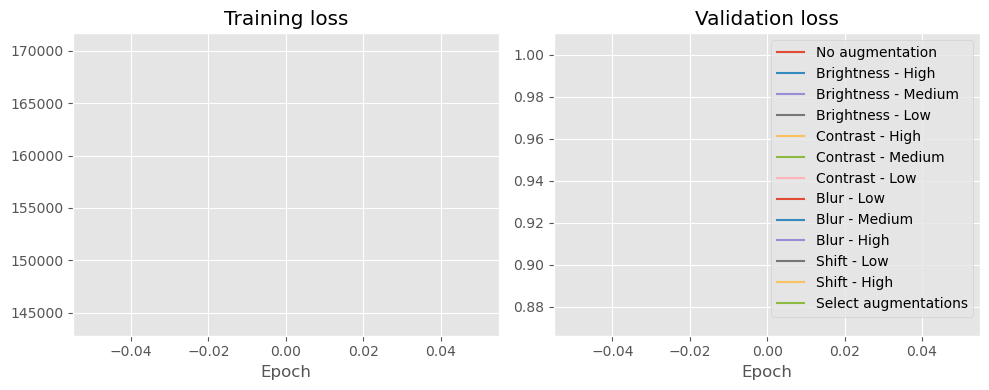

In [43]:
training_losses(aug_history,aug_description)()

<Figure size 1000x400 with 0 Axes>

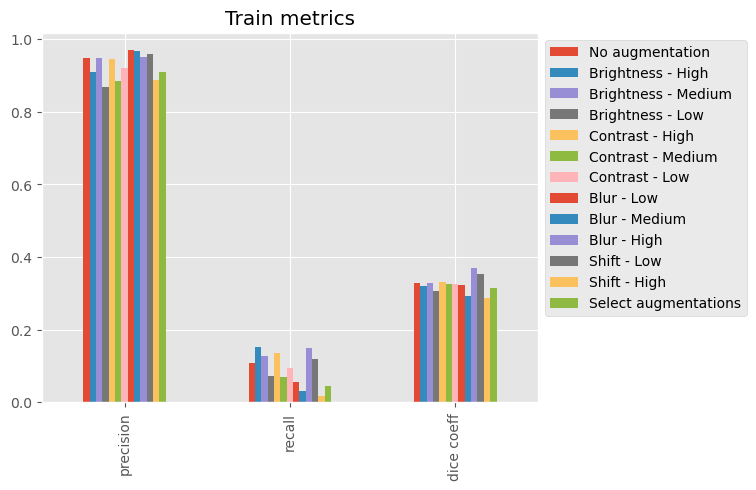

In [44]:
train_metrics(aug_history,aug_description)()

3/3 [==============================] - 2s 367ms/step


<Figure size 1000x400 with 0 Axes>

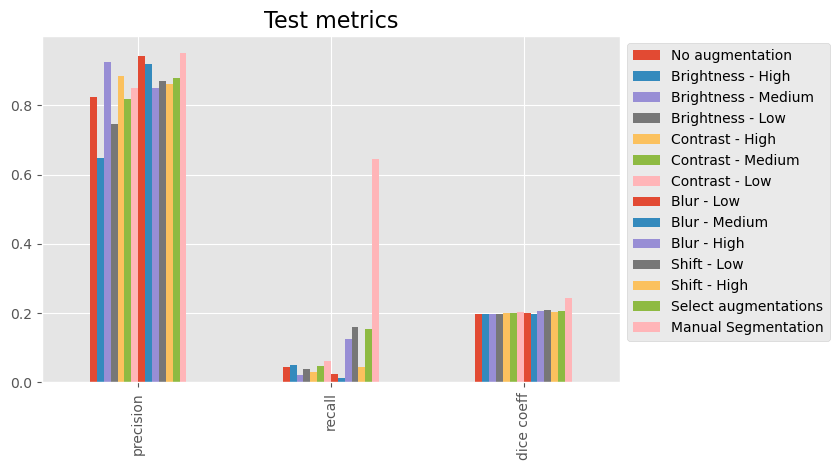

In [45]:
score_test(aug_models,aug_description,X_test_clean)

We see that a comination of select augmentations performs offers a significant performance boost. This model is selected as our final model and will be fine tuned to optimize performance.

### Visualizing Model Performance

In [46]:
#function for visualizing prediction results
def show_predictions(models,description,X_test,X_clean,img_num):
    try:
        row_num = len(models)
    except:
        row_num = 1
    col_num = img_num 
    count = 1

    plt.figure(figsize=(10,4))
    for n in range(img_num):
        ax = plt.subplot(row_num+2,col_num,count)
        plt.imshow(X_test[n])
        count += 1
        ax.set_xticks([])
        ax.set_yticks([])
        if n == 4:
            plt.title('Image')

    for n in range(row_num):
        try:
            y_pred = sigmoid(models[n].predict(X_test[:img_num+1]))>0.5
        except:
            y_pred = sigmoid(models.predict(X_test[:img_num+1]))>0.5
        for m in range(img_num):
            ax = plt.subplot(row_num+2,col_num,count)
            count += 1
            plt.imshow(y_pred[m])
            ax.set_xticks([])
            ax.set_yticks([])
            if m == 4:
                plt.title(description[n])

    for n in range(img_num):
        ax = plt.subplot(row_num+2,col_num,count)
        plt.imshow(X_clean[n])
        count += 1
        ax.set_xticks([])
        ax.set_yticks([])
        if n == 4:
            plt.title('Manual segmentation')

    plt.tight_layout()

1/1 [==============================] - 0s 256ms/step


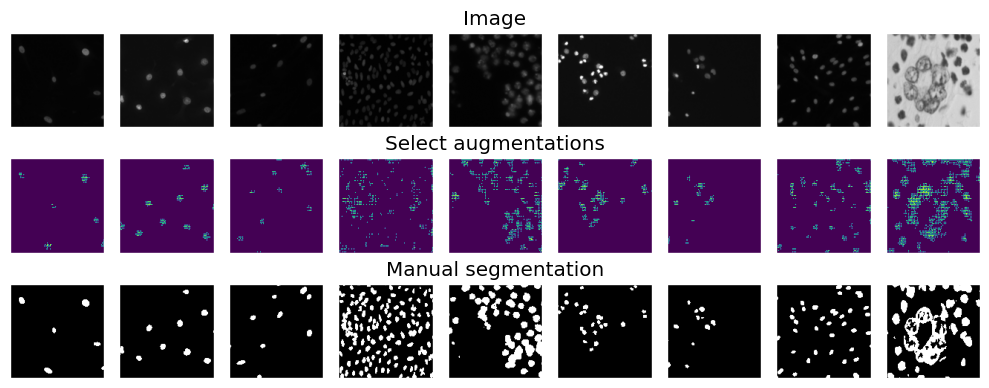

In [47]:
show_predictions(aug_models[-1:],aug_description[-1:],X_test,X_test_clean,9)

<h2><br></h2>
<h2>Fine-tuning selected model</h2>

In [61]:
#defining learning rate decay schedule
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
  
rate_decay = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [62]:
#defining model 
model = unet_model(bright=True,radius=4,brightness_delta=(-.1,.5),contrast=True,contrast_level=.2,blur=True,shift=True,shift_factor=0.001)

model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                                        loss=bce_dice_loss(smooth=100),
                                        metrics=[dice_coeff,tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Accuracy(name='accuracy')])

In [63]:
#training model
save_weights = ModelCheckpoint('loss', 
                    save_freq='epoch',
                    monitor='val_loss', 
                    save_best_only=True, 
                    save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=25, 
                                restore_best_weights=True)

final_history = model.fit(X_train,y_train, 
                        validation_data = (X_valid,y_valid),
                        epochs = 1000,
                        callbacks=[save_weights,early_stopping,rate_decay],
                        verbose=1)

Epoch 1/1000
17/17 [==============================] - 26s 1s/step - loss: 3.0552 - dice_coeff: 0.3925 - precision: 0.4248 - recall: 0.2981 - accuracy: 0.0000e+00 - val_loss: 1.4862 - val_dice_coeff: 0.5661 - val_precision: 0.9017 - val_recall: 0.3336 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/1000
17/17 [==============================] - 18s 1s/step - loss: 1.3317 - dice_coeff: 0.5953 - precision: 0.8470 - recall: 0.4365 - accuracy: 0.0000e+00 - val_loss: 1.1765 - val_dice_coeff: 0.6694 - val_precision: 0.9109 - val_recall: 0.4526 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/1000
17/17 [==============================] - 18s 1s/step - loss: 1.0934 - dice_coeff: 0.6617 - precision: 0.8535 - recall: 0.5328 - accuracy: 0.0000e+00 - val_loss: 0.9255 - val_dice_coeff: 0.7179 - val_precision: 0.9021 - val_recall: 0.5398 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/1000
17/17 [==============================] - 18s 1s/step - loss: 0.8624 - dice_coeff: 0.6993 - precision: 0.8547 - rec

<Figure size 1000x400 with 0 Axes>

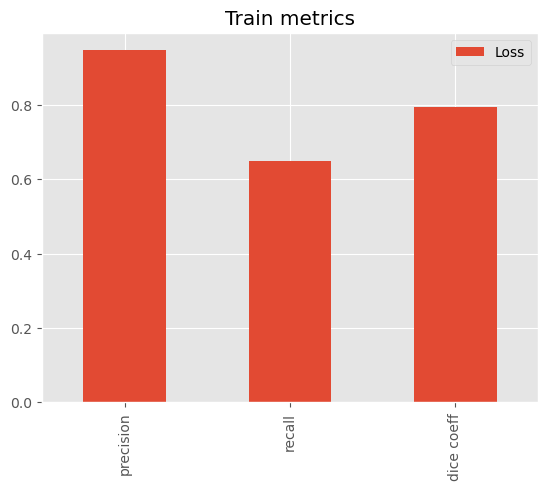

In [64]:
train_metrics([final_history],['Loss'])()

3/3 [==============================] - 2s 286ms/step


<Figure size 1000x400 with 0 Axes>

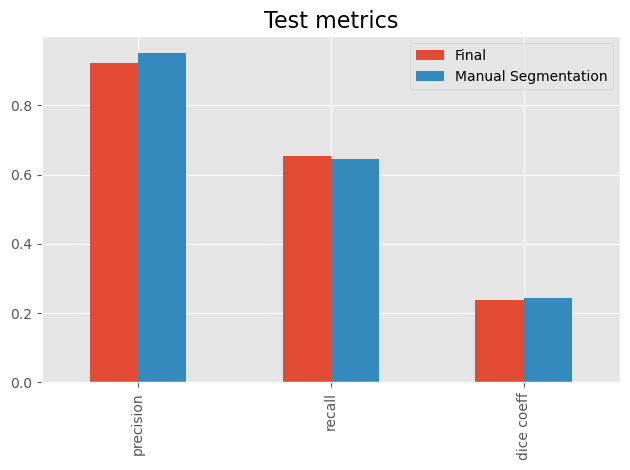

In [65]:
score_test([model],['Final'],X_test_clean)

1/1 [==============================] - 0s 191ms/step


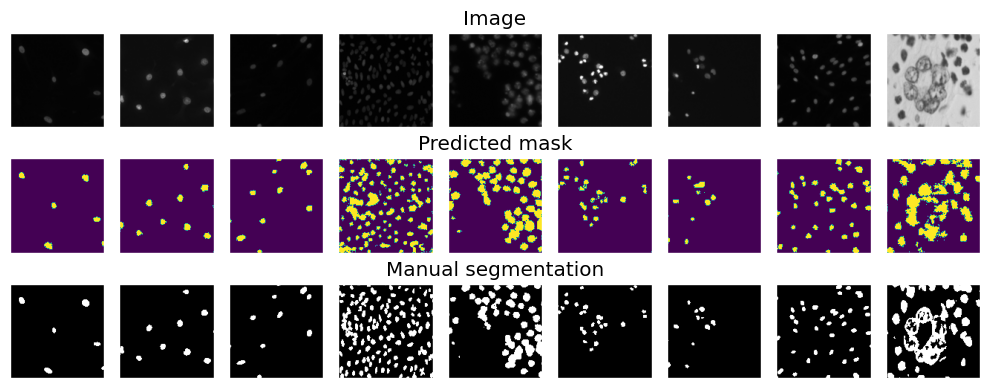

In [66]:
show_predictions(model,['Predicted mask'],X_test,X_test_clean,9)

1/1 [==============================] - 0s 205ms/step


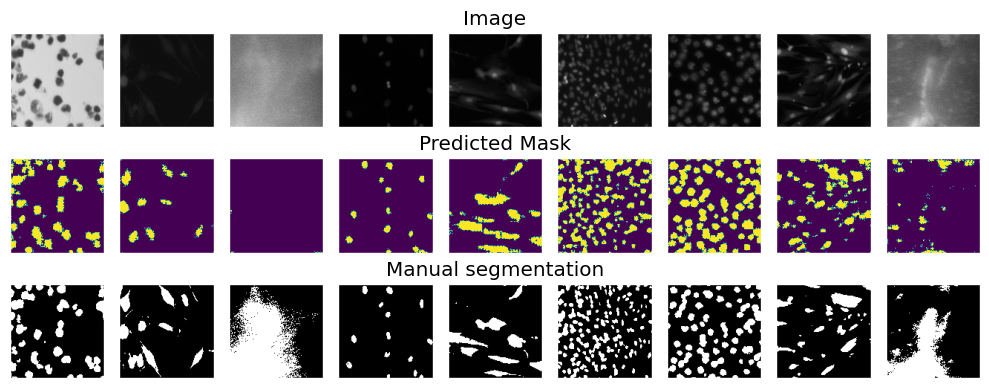

In [67]:
show_predictions(model,['Predicted Mask'],X_real[20:30],X_real_clean[20:30
],9)

We see that our model performs similarily to Otsu thresholding in terms of precision, recall and dice loss. On the set of real images, however, we see our semantic segmentation outperforming Otsu thresholding on images with high pixel intesnity from optical abberations as expected for a semantic segmentation model.